# CS 6320 Project 3: Projection Matrix and Fundamental Matrix Estimation

You are expected to complete this notebook with lines of code, plots and texts. You will need to create new cells with original code or text for your analyses and explanations. Explain what you do and analyze your results. This assignment has a total of 100 points distributed for two sub-parts listed below.

(1) Projection Matrix  
(2) Fundamental Matrix Estimation  

# Brief
    Due Data: Listed in Canvas
    Hand-in : Through Gradescope
    Required files: <your_uid>.zip.(Please begin with 'u' for your uid)


## Setup

   0. Unzip proj3_6320.zip and go to proj3_6320 directory.
      - You can run `unzip proj3_6320.zip && cd proj3_6320` in your terminal.
   1. Install [Miniconda](https://docs.conda.io/en/latest/miniconda.html). It doesn’t matter whether you use Python 2 or 3 because we will create our own environment that uses 3 anyways.
   2. Create a conda environment using the appropriate command. On Windows, open the installed “Conda prompt” to run the command. On MacOS and Linux, you can just use a terminal window to run the command, Modify the command based on your OS (linux, mac, or win): `conda env create -f proj3_env_<OS>.yml`.
    - NOTE that proj3_env_<OS>.yml is inside the project folder.
   3. This should create an environment named ‘proj3’. Activate it using the Windows command, activate proj3 or the MacOS / Linux command, conda activate proj3
   4. Run the notebook using `jupyter notebook` under *proj3_6320* directory.
   6. Generate the zip folder for the code portion of your submission once you’ve finished the project using 
    
        `python zip_submission.py --uid <your_uid>` 


## Writeup
For this project, this notebook itself is the report. You must answer each of the questions (associated with each part) in a separate cell. **You must run all your cells before you hand in it.** Your code, results, visualization, and discussion will be used for the grading. **You will be deducted points if the results are not shown in this notebook**. Do not change the order of the cells. You can add cells in need. You can copy a cell and run it seperately if you need to run a cell multiple times and thus every result is displayed in the cell.


## Rubric
    +49 pts: Part_1
    +51 pts: Part_2

    -5 pts: Lose 5 points for every time you do not follow the instructions for the hand-in format.
    
Submission Format

This is very important as you will lose 5 points for every time you do not follow the instructions. You will attach only one items in your submission on Canvas:

1. <your_uid>.zip containing:
    - proj3_code/ - directory containing all your code for this assignment
    - data/       - directory containing all the input images
    - results/    - directory containing all the output images

Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Do not use absolute paths in your code or your code will break. Use relative paths. Failure to follow any of these instructions will lead to point deductions. Create the zip file using python zip_submission.py --uid <your_uid> (it will zip up the appropriate directories/files for you!)

## Setup

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1 Projection Matrix Estimation

## Part 1.1 Implement Camera Projection (6pts)

In this initial part, in `projection_matrix.py` you will implement camera projection in the `projection(P, points_3d)` from homogenous world coordinates $X_i = [X_i, Y_i, Z_i, 1]$ to non-homogenous pixel coordinates $x_i, y_i$.

It will be helpful to recall the equations to convert to pixel coordinates

\begin{align}
x_i = \frac{p_{11}X_i+p_{12}Y_i + p_{13}Z_i + p_{14}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}} \quad y_i = \frac{p_{21}X_i+p_{22}Y_i + p_{23}Z_i + p_{24}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}}
\end{align}

In [4]:
import projection_matrix
# np.set_printoptions(suppress=True) # Suppresses printing in scientific notation

from unit_tests.part1_unit_test import (
    verify, 
    test_projection, 
    test_objective_func,
    test_decompose_camera_matrix,
    test_calculate_camera_center,
    test_estimate_camera_matrix)

In [15]:
print('Test for camera projection:', verify(test_projection))

Test for camera projection: "Correct"


## Part 1.2: Objective Function (6pts)

In this part, in `projection_matrix.py` you will implement the objective function `objective_function(x, **kwargs)` that will be passed to `scipy.optimize.least_squares` for minimization with the Levenberg-Marquardt algorithm. The input to this function is a [vectorized](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) camera matrix, the output is the term that gets squared in the objective function and should also be vectorized. Scipy takes care of the squaring + summation part.

\begin{align}
\sum_{i=1}^N ( \color{purple}{\hat{\mathbf{P}}\mathbf{X}_w^i-\mathbf{x}^i })^2
\end{align}

In [16]:
print('Test for objective_function:', verify(test_objective_func))

Test for objective_function: "Correct"


## Part 1.3: Estimating the Projection Matrix Given Point Correspondences (6pts)

Initially you will run the optimization to estimate $\mathbf{P}$ using an initial guess that we provide. You will implement the function `estimate_camera_matrix` in `projection_matrix.py`.

### Good initial estimate for $\mathbf{P}$.

Optimizing the reprojection loss using Levenberg-Marquardt requires a good initial estimate for $\mathbf{P}$. This can be done by having good initial estimates for $\mathbf{K}$ and $\mathbf{R}^T$ and $\mathbf{t}$ which you can multiply to then generate your estimated $\mathbf{P}$.

In [172]:
initial_guess_K = np.array([[ 500,   0, 535],
                            [   0, 500, 390],
                            [   0,   0,  -1]])

initial_guess_R_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_I_t = np.array([[   1,    0, 0, 300],
                              [   0,    1, 0, 300],
                              [   0,    0, 1,  30]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [173]:
# set the paths and load the data
pts2d_path = '../data/pts2d-pic_b.txt'
pts3d_path = '../data/pts3d.txt'
img_path   = '../data/pic_b.jpg'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(img_path)

### Estimate the projection matrix given corresponding 2D & 3D points

In [174]:
print('Test for estimate_camera_matrix:', verify(test_estimate_camera_matrix))

`xtol` termination condition is satisfied.
Function evaluations 64, initial cost 2.9929e+07, final cost 6.8831e+00, first-order optimality 5.18e+01.
Time since optimization start 0.10856103897094727
Test for estimate_camera_matrix: "Wrong"


`xtol` termination condition is satisfied.
Function evaluations 64, initial cost 2.9929e+07, final cost 6.8831e+00, first-order optimality 5.18e+01.
Time since optimization start 0.09682416915893555
The projection matrix is
 [[-2.04557984e+00  1.18133640e+00  4.05427132e-01  2.44815596e+02]
 [-4.55835436e-01 -3.04130307e-01  2.14984872e+00  1.66185784e+02]
 [-2.24226330e-03 -1.09951540e-03  5.71330711e-04  1.00000000e+00]]
The total residual is 14.715028


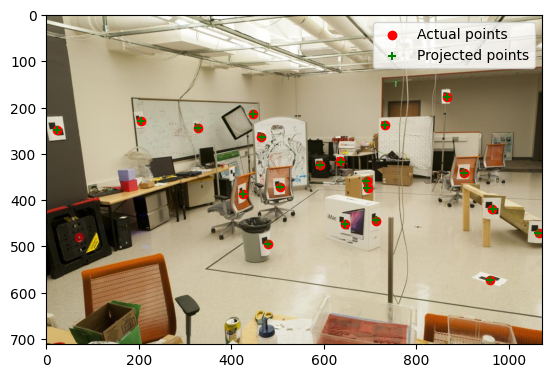

In [175]:
P = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)

print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/pic_b.jpg')


## Part 1.4: Decomposing the projection matrix (6pts)

In this part in `projection_matrix.py` you will implement `decompose_camera_matrix(P)` that takes as input the camera matrix $\mathbf{P}$ and outputs the intrinsic $\mathbf{K}$ and rotation matrix $\mathbf{R}^c_w$ (rotation in camera coordinates), 

In [176]:
print('Test for decomposing projection matrix:', verify(test_decompose_camera_matrix))
K, R = projection_matrix.decompose_camera_matrix(P)

Test for decomposing projection matrix: "Correct"


## Part 1.5: Calculating Camera Center (6pts)

In this part in `projection_matrix.py` you will implement `calculate_camera_center(P, K, R)` that takes as input the 
projection $\mathbf{P}$, intrinsic $\mathbf{K}$ and extrinsic $\mathbf{R}^c_w$ matrix and outputs the camera position in world coordinates.

In [177]:
print('Test for calculating camera center:', verify(test_calculate_camera_center))
center = projection_matrix.calculate_camera_center(P, K, R)

Test for calculating camera center: "Correct"


We can now visualize the camera center and the camera coordinate system as well as the  the world coordinate system.

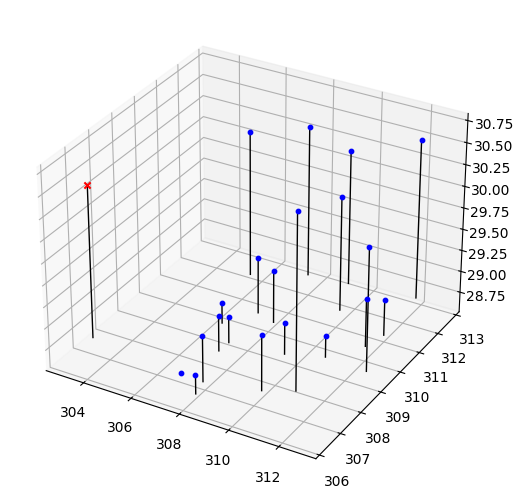

In [24]:
plot3dview(points_3d, center)

## Part 1.6: Taking Your Own Images and Estimating the Projection Matrix + Camera Pose (5pts)

In this part you will take two images of your fiducial object. If you want to also reuse these images for Part II, keep in mind how to take good images for estimating the Fundamental Matrix.<br>
An image of a textbook or box in a contrasting background can be used, with one of its corners designated as the origin of the world coordinate system. This will simplify the calculation of the coordinates for the corners and other points on the object.

In [32]:
image1_path = '../data/new_book_img1.jpg'
image2_path = '../data/new_book_img2.jpg'

img1 = load_image(image1_path)
img2 = load_image(image2_path)

# w = 20.3 cm
# l = 26.7 cm
# h = 1.2 cm

Measure your fiducial object and define a coordinate system. Fill out the `points_3d` variable with the 3D point locations of the points you'll use for correspondences.

In [33]:
points_3d = np.array([
    [0.0, 0.0, 0.0],   # bottom-left-back (origin) 
    [0.0, 0.0, 1.2],   # bottom-left-front
    [20.3, 0.0, 0.0],   # bottom-right-back
    [20.3, 0, 1.2],   # bottom-right-front
    [0.0, 26.7, 1.2],   # top-left-front
    [20.3, 26.7, 1.2]    # top-right-front
])

Now for each image, find the 2D pixel locations of your 3D points. Hovering over the image gives you the `x,y` coordinates of your cursor on the image. You can use the lower left side controls to zoom into the image for more precise measurements. Fill out `points2d_img1` with these coordinate values.

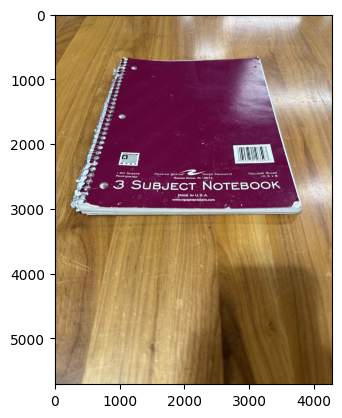

In [34]:
# plotting image 1
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img1)

In [35]:
points2d_img1 = np.array([[418, 3085], [375, 2933], [3752, 3088], [3770, 2966], [1040, 698], [3138, 675]])

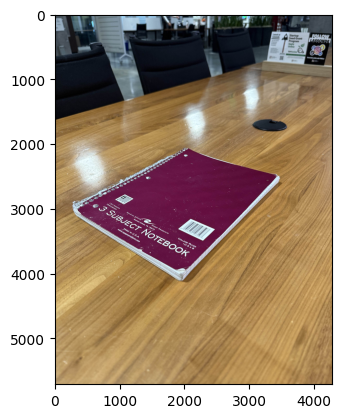

In [36]:
# plotting image 2
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img2)

In [37]:
points2d_img2 = np.array([[296, 3095], [292, 2965], [1946, 4115], [1952, 3991], [2016, 2075], [3432, 2495]])

Our objective function will need to read the measurements you just saved from disk. We need to save this data now.

In [38]:
np.savetxt('../results/pts3d_fiducial.npy', points_3d)
np.savetxt('../results/pts2d_image1.npy', points2d_img1)
np.savetxt('../results/pts2d_image2.npy', points2d_img2)

## Part 1.7: Making your own $\mathbf{K}$,  $\mathbf{R}^T$ and $[\mathbf{I}|\mathbf{t}]$ estimates. (5pts)

When estimating the projection matrix, it’s crucial to have reasonable initial guesses for the following:
- The **first two diagonal elements of \(K\)** correspond to the **focal length** of the camera used to take the images. The **last column values of \(K\)** correspond to the **center of the image**.  
- \(R_T\) and (\(I_t\)) represents the **rotation and translation** of the camera with respect to the world coordinates.  

Provide an initial good estimates for these values below.


In [178]:
# initial_guess_K = np.array([[   1,   0,  0],
#                             [   0,   1,  0],
#                             [   0,   0,  1]])

# initial_guess_R_T = np.array([[ 1,   0, 0],
#                               [ 0,   1, 0],
#                               [ 0,   0, 1]])

# initial_guess_I_t = np.array([[   1,    0, 0, 80],
#                               [   0,    1, 0, 290],
#                               [   0,    0, 1, -150]])

#############################################################

# initial_guess_K = np.array([[ 4000,     0, 2000],
#                             [     0,  4000, 2000],
#                             [     0,     0,    1]])

# initial_guess_R_T = np.array([[ 1,   0, 0],
#                               [ 0,   1, 0],
#                               [ 0,   0, 1]])

# initial_guess_I_t = np.array([[   1,    0, 0, 80],
#                               [   0,    1, 0, 290],
#                               [   0,    0, 1, -150]])

################################################################

# initial_guess_K = np.array([[1500,    0, 2000],
#                             [   0, 1500, 1500],
#                             [   0,    0,    1]])

# initial_guess_R_T = np.array([[ 0.995000, -0.019833,  0.097840],
#                               [ 0.000000,  0.980067,  0.198669],
#                               [-0.099833, -0.197690,  0.975150]])

# initial_guess_I_t = np.array([[   0.995000,  -0.019833,   0.097840,   100],
#                               [   0.000000,   0.980067,   0.198669,    50],
#                               [  -0.099833,  -0.197690,   0.975150,  2000]])

##############################################################

# initial_guess_K = np.array([[3200,    0, 2000],
#                             [   0, 3200, 1500],
#                             [   0,    0,    1]])

# initial_guess_R_T = np.array([[ 1.000000,  0.000000,  0.000000],
#                               [ 0.000000,  1.000000,  0.000000],
#                               [ 0.000000,  0.000000, -1.000000]])

# initial_guess_I_t = np.array([[   1,    0,    0,   -40],
#                               [   0,    1,    0,   -10],
#                               [   0,    0,    1,  1500]])

###########################################################

initial_guess_K = np.array([[2730,    0, 1311],
                            [   0, 2730,  603],
                            [   0,    0,    1]])

initial_guess_R_T = np.array([[ 1.000000,  0.000000,  0.000000],
                              [ 0.000000,  0.999848, -0.017452],
                              [ 0.000000,  0.017452,  0.999848]])

initial_guess_I_t = np.array([[   1,    0,    0,   -20],
                              [   0,  0.999848, -0.017452,   -10],
                              [   0,  0.017452,  0.999848,  1800]])






initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [179]:
# set the paths and load the data
pts2d_path = '../results/pts2d_image1.npy'
pts3d_path = '../results/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)

Visualize your estimate for the camera pose relative to the world coordinate system. RGB colors correspond with XYZ (first, second and third coordinate). Be mindful of whether you should be passing `R` or `R.T` in for your rotation matrix.

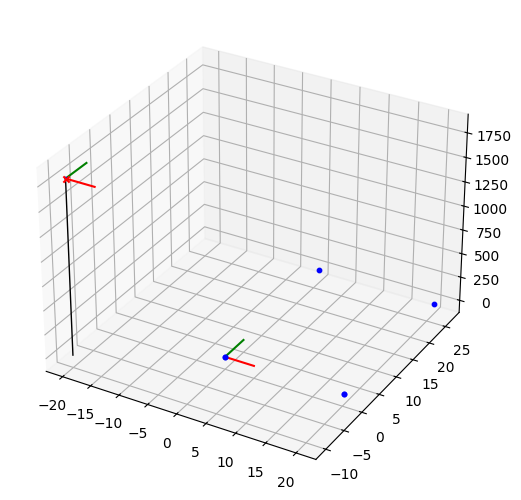

In [181]:
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_R_T.T)

View the optimization results given your initial guess. If your initial guess is poor the optimizition **will not** work. You will need to make initial estimates for both the images you took.

`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 8.3488e+12, final cost 1.3461e+02, first-order optimality 8.10e-04.
Time since optimization start 0.01688981056213379
The projection matrix is
 [[ 1.60184339e+02  4.78545061e+01 -4.14991819e+01  4.18046290e+02]
 [-2.40212408e+00 -6.68656377e+01 -1.56754165e+02  3.07689296e+03]
 [-1.07879868e-03  2.24932399e-02 -1.49175880e-02  1.00000000e+00]]
The total residual is 34.274844


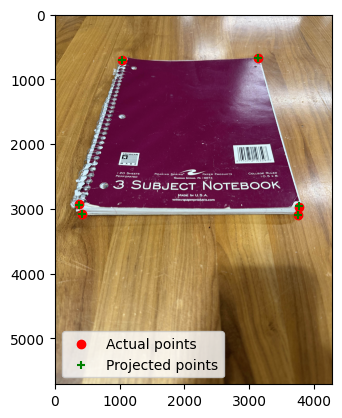

In [182]:
P1 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
print('The projection matrix is\n', P1)

[projected_2d_pts, residual] = evaluate_points(P1, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image1_path)

Visualize your estimate for the camera pose relative to the world coordinate system.

In [183]:
# set the pats and load the data
pts2d_path = '../results/pts2d_image2.npy'
pts3d_path = '../results/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([2856., 2142.])

In [189]:
# initial_guess_K = np.array([[   1,   0,  0],
#                             [   0,   1,  0],
#                             [   0,   0,  1]])

# initial_guess_K = np.array([[ 4000,     0, 2000],
#                             [     0,  4000, 2000],
#                             [     0,     0,    1]])

# initial_guess_R_T = np.array([[ 1,   0, 0],
#                               [ 0,   1, 0],
#                               [ 0,   0, 1]])

# initial_guess_I_t = np.array([[1, 0, 0, 80],
#                               [0, 1, 0, 290],
#                               [0, 0, 1, -160]])

initial_guess_K = np.array([[2730,    0, 1311],
                            [   0, 2730,  603],
                            [   0,    0,    1]])

initial_guess_R_T = np.array([[ 1.000000,  0.000000,  0.000000],
                              [ 0.000000,  0.999848, -0.017452],
                              [ 0.000000,  0.017452,  0.999848]])

initial_guess_I_t = np.array([[   1,    0,    0,   -20],
                              [   0,  0.999848, -0.017452,   -10],
                              [   0,  0.017452,  0.999848,  1800]])


# img = load_image(image1_path)
# Himg, Wimg = img.shape[:2]
# cx, cy = Wimg/2, Himg/2
# f = 1.2 * max(Wimg, Himg)

# initial_guess_K = np.array([
#     [f, 0, cx],
#     [0, f, cy],
#     [0, 0,  1]
# ], dtype=float)

# initial_guess_R_T = np.eye(3, dtype=float)

# initial_guess_I_t = np.array([
#     [1, 0, 0, 100.0],
#     [0, 1, 0, 120.0],
#     [0, 0, 1, -600.0],
# ], dtype=float)



initial_guess_P2 = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

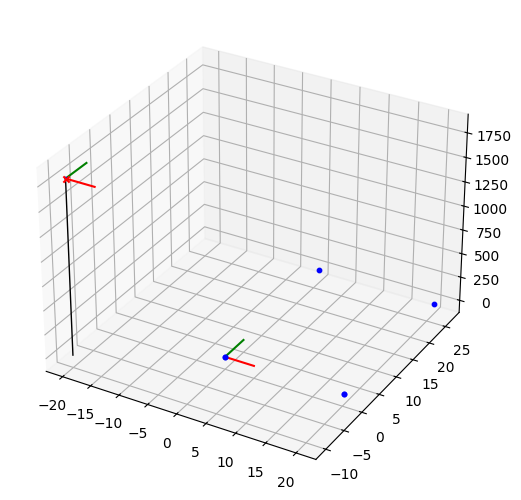

In [190]:
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_R_T.T) #change this plot to show the world coordinate system better

`ftol` termination condition is satisfied.
Function evaluations 15, initial cost 8.3519e+12, final cost 1.3396e+02, first-order optimality 1.35e-03.
Time since optimization start 0.009636640548706055
The projection matrix is
 [[ 5.56763873e+01  9.78900457e+01 -1.48483270e+01  3.00838229e+02]
 [-2.53493056e+00  1.82115229e+00 -1.30022309e+02  3.08731391e+03]
 [-1.29684990e-02  1.68820489e-02 -1.17317469e-02  1.00000000e+00]]
The total residual is 33.839658


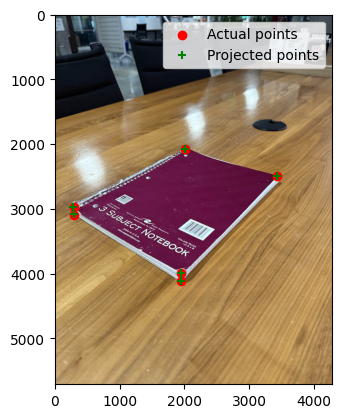

In [191]:
P2 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P2)
#M = sc.calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', P2)

[projected_2d_pts, residual] = evaluate_points(P2, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image2_path)
#visualize_points(points_2d, projected_2d_pts)

## Part 1.8 Visualizing both camera poses in the world coordinate system (4pts)

[ 12.30784426 -24.144329    29.73926682]
[ 32.72193043 -18.21811857  22.85137179]


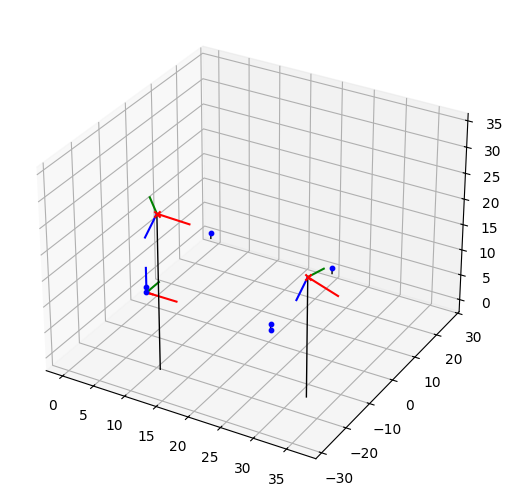

In [188]:
K1, R1 = projection_matrix.decompose_camera_matrix(P1)
center_1 = projection_matrix.calculate_camera_center(P1, K1, R1);
print(center_1)

K2, R2 = projection_matrix.decompose_camera_matrix(P2)
center_2 = projection_matrix.calculate_camera_center(P2, K2, R2);
print(center_2)

plot3dview_2_cameras(points_3d, center_1, center_2, R1, R2)

## Part 1.9 Questions (5pts):

1. What would happen to the projected points if you increased/decreased the x coordinate, or the other coordinates of the camera center t? Write down a description of your expectations in the appropriate part of your writeup submission.

#### Answer 

They would all move around together like a set. They will move towards the opposite of where the camera is being moved.

2. Perform this shift for each of the camera coordinates and then recompose the projection matrix and visualize the result in your Jupyter notebook. You could use the image given as the part of the assignment for this analyses.

In [196]:
initial_guess_K = np.array([[2730,    0, 1311],
                            [   0, 2730,  603],
                            [   0,    0,    1]])

initial_guess_R_T = np.array([[ 1.000000,  0.000000,  0.000000],
                              [ 0.000000,  0.999848, -0.017452],
                              [ 0.000000,  0.017452,  0.999848]])

initial_guess_I_t = np.array([[   1,    0,    0,   -20],
                              [   0,  0.999848, -0.017452,   -10],
                              [   0,  0.017452,  0.999848,  1800]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [197]:
# set the pats and load the data
pts2d_path = '../results/pts2d_image1.npy'
pts3d_path = '../results/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([2856., 2142.])

`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 8.3488e+12, final cost 1.3461e+02, first-order optimality 8.10e-04.
Time since optimization start 0.011364459991455078
The projection matrix is
 [[ 1.60184339e+02  4.78545061e+01 -4.14991819e+01  4.18046290e+02]
 [-2.40212408e+00 -6.68656377e+01 -1.56754165e+02  3.07689296e+03]
 [-1.07879868e-03  2.24932399e-02 -1.49175880e-02  1.00000000e+00]]
The total residual is 34.274844


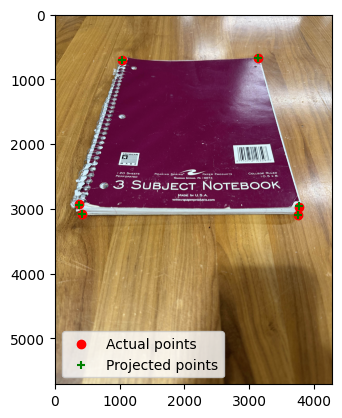

In [198]:
P = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)

print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image1_path)

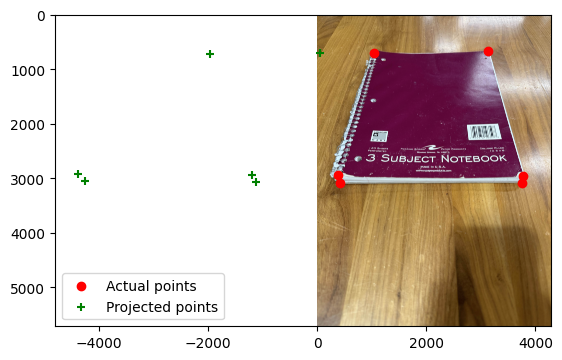

In [214]:

K, R = projection_matrix.decompose_camera_matrix(P)
C = projection_matrix.calculate_camera_center(P, K, R)
C_n = C.copy()
C_n[0] += 30
t_n = -R @ C_n
P_n = K @ np.hstack([R, t_n.reshape(3, 1)])
projected_shift_2d = projection_matrix.projection(P_n, points_3d)

visualize_points_image(points_2d, projected_shift_2d, image1_path)


# Part 2 Fundamental Matrix Estimation

In this part you'll be estimating the fundamental matrix. You'll be using a least squares optimizer from SciPy. (Documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

The least squares optimizer takes an objective function, your variables to optimize, and the points that you want to fit a line to. In this case, the objective function is to minimize the point to line distance, where the line is the projection of a point onto another image by the fundamental matrix, and the point is an actual point of a feature in that image. The variable that you want to optimize would be the 9 values in the 3x3 Fundamental Matrix. The points that you are optimizing over are provided to you, and they are the homogeneous coordinates of corresponding features from two different images of the same scene.

## Part 2.1 Estimate Fundamental Matrix (20pts)

Implement the `point_line_distance()` method in fundamental_matrix.py.

\begin{align}
    d(line, point) = \frac{au + bv + c}{\sqrt{a^2 + b^2}}
\end{align}

In [74]:
from unit_tests.test_fundamental_matrix import verify
from unit_tests.test_fundamental_matrix import TestFundamentalMatrix

test_fundamental_matrix_stereo = TestFundamentalMatrix()
TestFundamentalMatrix.setUp(test_fundamental_matrix_stereo)
print("test_point_line_distance(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance))
print("test_point_line_distance_zero(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance_zero))

test_point_line_distance(): "Correct"
test_point_line_distance_zero(): "Correct"


Implement `signed_point_line_errors()`.

Keep in mind that SciPy does the squaring and summing for you, so all you have to do in `signed_point_line_errors()` is return a list of each individual error. So if there are 9 points, you have to calculate the `point_line_distance()` between each pair from $Fx_1$ to $x_0$ and also $F^Tx_0$ to $x_1$, then append all errors to a list, such that you end up returning a list of length 18. SciPy will take the list and square each element and sum everything for you. 

`signed_point_line_errors()`:
\begin{align}
    \color{red}{d(Fx_1, x_0)}^2 + \color{red}{d(F^T x_0, x_1)}^2
\end{align}

You'll also have to make the call to SciPy's least squares optimizer in the `optimize()` method in least_squares_fundamental_matrix.py.

In [76]:
from unit_tests.test_fundamental_matrix import TestFundamentalMatrix2, TestFundamentalMatrix3

print("TestFundamentalMatrix():")
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_stereo.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_stereo.test_least_squares_optimize))

print("TestFundamentalMatrix2():")
test_fundamental_matrix_synthetic = TestFundamentalMatrix2()
TestFundamentalMatrix2.setUp(test_fundamental_matrix_synthetic)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_synthetic.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_synthetic.test_least_squares_optimize))

print("TestFundamentalMatrix3():")
test_fundamental_matrix_real = TestFundamentalMatrix3()
TestFundamentalMatrix3.setUp(test_fundamental_matrix_real)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_real.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_real.test_least_squares_optimize))

TestFundamentalMatrix():
test_signed_point_line_errors(): "Correct"
test_least_squares_optimize(): "Correct"
TestFundamentalMatrix2():
test_signed_point_line_errors(): "Correct"
test_least_squares_optimize(): "Correct"
TestFundamentalMatrix3():
test_signed_point_line_errors(): "Correct"
test_least_squares_optimize(): "Correct"


Then run the following cell to find the Fundamental Matrix using least squares. You should see the epipolar lines in the correct places in the image.

[[-1.16412649e-02  1.23147069e-01 -3.03081411e+00]
 [ 1.81051240e-01 -3.20585712e-02 -4.97432158e+02]
 [-4.62059973e+01  3.62983661e+02  1.18585731e+04]]


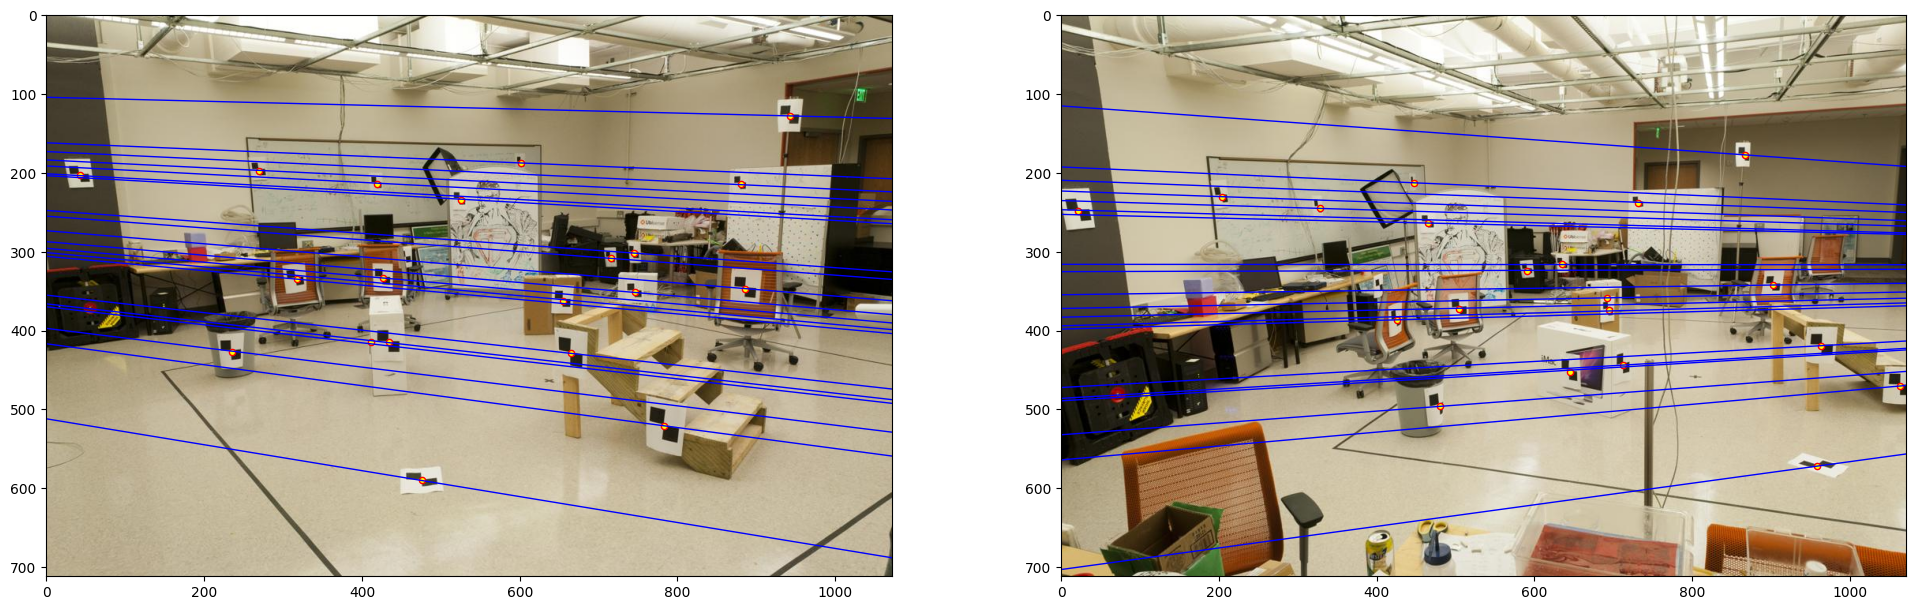

In [77]:
%matplotlib inline
# Load the data for room images
points_2d_pic_a = np.loadtxt('../data/pts2d-pic_a.txt')
points_2d_pic_b = np.loadtxt('../data/pts2d-pic_b.txt')
img_left = load_image('../data/pic_a.jpg')
img_right = load_image('../data/pic_b.jpg')

import least_squares_fundamental_matrix as ls

F = ls.solve_F(points_2d_pic_a, points_2d_pic_b)
print(F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_left, img_right, points_2d_pic_a, points_2d_pic_b)

## Part 2.2 Try Fundamental Matrix Estimation Yourself (15pts)

Now you're going to take two images yourself and estimate the fundamental matrix between them. To do this, take two images and save them as "my_image_0.jpg" and "my_image_1.jpg" in the "/data" folder. You will want an image with lots of features at varying depths.

In [78]:
# Load the data for room images
# my_img_left = load_image('../data/my_image_0_new.jpg')
# my_img_right = load_image('../data/my_image_1_new.jpg')

# image1_path = '../data/new_book_img1.jpg'
# image2_path = '../data/new_book_img2.jpg'

my_img_left = load_image('../data/new_book_img1.jpg')
my_img_right = load_image('../data/new_book_img2.jpg')

To collect your own data points, run the following cell and mouse over features in the image and record the x- and y-coordinates. You'll need at least 9 points because we are trying to optimize for 9 variables, one for each element in the 3x3 fundamental matrix. Think about how you can choose good features for estimating the fundamental matrix.

**Store your points in variable "my_image_0_pts" and "my_image_1_pts" respectively.**

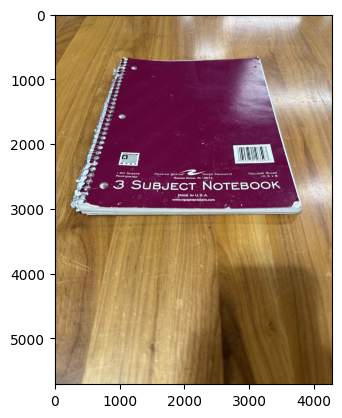

In [79]:
%matplotlib inline
# plotting image 1
image_0 = plt.figure(); image_0_ax = image_0.add_subplot(111); image_0_ax.imshow(my_img_left)

In [109]:
#my_image_0_pts = np.array([[0, 0]]) # Record your coordinates here
# my_image_0_pts = np.array([[336.0, 1900.0], [202.0, 1673.0], [1226.0, 425.0], [3359.0, 731.0], [3284.0, 2406.0], [3192.0, 2618.0], [1088.0, 857.0], [1952.0, 965.0], [3002.0, 1263.0], [2253.0, 571.0]])

my_image_0_pts = np.array([[418, 3085], [375, 2933], [3752, 3088], [3770, 2966], [1040, 698], [3138, 675], [2748, 2024], [3310, 2007], [2776, 2307], [3383, 2292]])

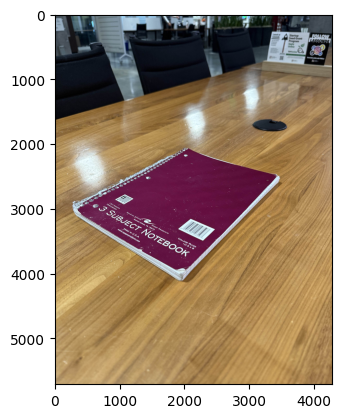

In [110]:
# plotting image 2
image_1 = plt.figure(); image_1_ax = image_1.add_subplot(111); image_1_ax.imshow(my_img_right)

In [111]:
#my_image_1_pts = np.array([[0, 0]]) # Record your coordinates here
# my_image_1_pts = np.array([[2339.0, 2856.0], [2387.0, 2629.0], [854.0, 11218.0], [2528.0, 444.0], [3936.0, 1170.0], [3899.0, 1367.0], [1576.0, 1557.0], [2242.0, 1106.0], [2979.0, 813.0], [1844.0, 768.0]])
my_image_1_pts = np.array([[296, 3095], [292, 2965], [1946, 4115], [1952, 3991], [2016, 2075], [3432, 2495], [2092, 3161], [2463, 3322], [1899, 3318], [2279, 3500]])

[[-1.07946367e+00  1.80149470e+00 -4.93269951e+03]
 [-2.45512501e+00 -3.03392747e+00  7.33180902e+03]
 [ 5.50396683e+03  1.14583270e+04 -2.86348391e+07]]


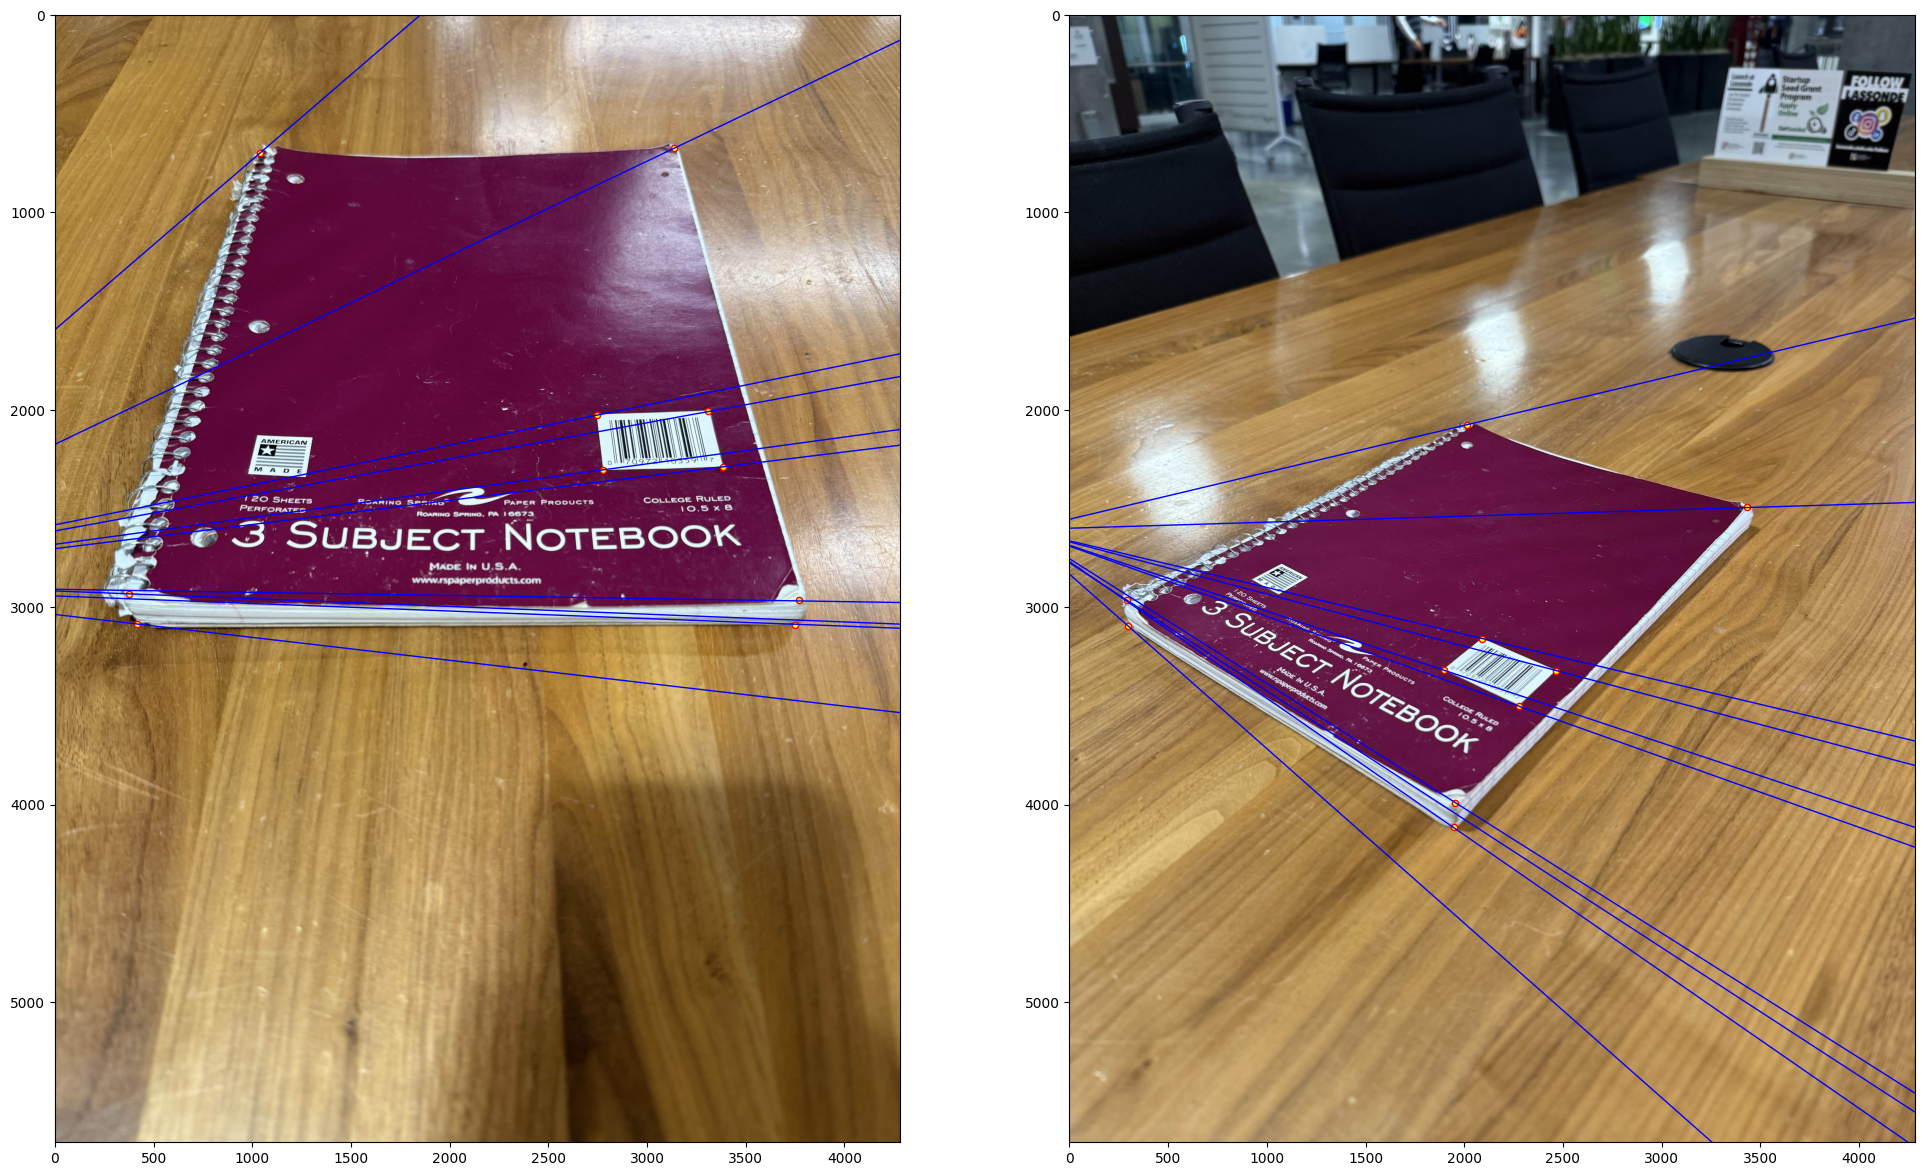

In [112]:
%matplotlib inline
import two_view_data as two_view_data
my_F = ls.solve_F(my_image_0_pts, my_image_1_pts)
print(my_F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(my_F, my_img_left, my_img_right, my_image_0_pts, my_image_1_pts)

## Part 2.3 Questions (16pts)

1. Why is it that when you take your own images, you can’t just rotate the camera or zoom the image for your two images of the same scene?
2. Why is it that points in one image are projected by the fundamental matrix onto epipolar lines in the other image?
3. What happens to the epipoles and epipolar lines when you take two images where the camera centers are within the images? Why?
4. What does it mean when your epipolar lines are all horizontal across the two images?


#### Answer 1

You need to move the camera to get a different angle of the same scene. Zooming will keep the same angle, you will just come closer or farther. Rotating will keep the same angle for the same scene and add a new part to the scene. The camera center remains the same. The triangulation needed is nto created when we do zoom or rotation. To create a parallax, you need to physically move the camera.

#### Answer 2

The fundamental matrix encodes the epipolar geometry between two views, so a point in one image defines an epipolar plane with the two camera centers and that plane intersects the other image in a line; any true correspondence must lie on that epipolar line. 

#### Answer 3

The epipoles will be visible in both pictures. All epipolar lines pass throgh these epipolar points, so it will look like epipolar lines are coming out from the epipole points. 

#### Answer 4

The epipoles are at infinity at the horizantal axis, and that means the relative motion between the 2 cameras is a pure horizontal translation. matchin the 2 images will become a 1d scan of the corrosponding row. 